# Analysis of Crime Data in Cuyahoga County

In [1]:
import requests
import json
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from citipy import citipy
import numpy as np
from scipy.stats import linregress

from api_keys import weather_api_key
from api_keys import fbi_key



## Pulled 2017 crime data from OCJS website for Ohio

In [2]:
crime_2017 = pd.read_csv("ocjs_crimebycounty2017.csv")
crime_2017.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OH02538,OHIO DEPT OF NATURAL RESOURCES,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,OHOHP00,OHIO STATE HGHWAY PATROL,NaN,280,209,3.0,42,6,229,3,157,49,4
2,NaN,TOTAL,NaN,280,209,3.0,42,6,229,3,157,49,4
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,OH00102,PEEBLES,"1,746",3,3,NaN,NaN,NaN,3,1,1,1,NaN


### Narrowed dataframe to Cuyahoga County only

In [3]:
cuy_crime=crime_2017.loc[153:199, :].reset_index(drop=True)
cuy_crime.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OHCLP00,CLEVELAND,"385,351","5,999","18,944",107.0,497,"2,697","2,698","5,853","9,696","3,395",253
1,OH018A1,NOTRE DAME COLLEGE,NaN,2,38,NaN,2,NaN,NaN,9,29,NaN,NaN
2,OH01801,BAY VILLAGE,"15,327",2,73,NaN,1,NaN,1,11,61,1,NaN
3,OH01803,BEDFORD,"12,641",25,228,1.0,1,16,7,50,146,32,NaN
4,OH01804,BEDFORD HEIGHTS,"10,558",22,255,1.0,1,9,11,32,173,50,NaN


### Converted all null values to zero

In [4]:
cuy_crime_null=cuy_crime.fillna(0)
cuy_crime_null.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OHCLP00,CLEVELAND,"385,351","5,999","18,944",107.0,497,"2,697","2,698","5,853","9,696","3,395",253
1,OH018A1,NOTRE DAME COLLEGE,0,2,38,0.0,2,0,0,9,29,0,0
2,OH01801,BAY VILLAGE,"15,327",2,73,0.0,1,0,1,11,61,1,0
3,OH01803,BEDFORD,"12,641",25,228,1.0,1,16,7,50,146,32,0
4,OH01804,BEDFORD HEIGHTS,"10,558",22,255,1.0,1,9,11,32,173,50,0


### Deleted rows where Population equals zero

In [5]:
cuy_data=cuy_crime_null.drop(cuy_crime_null[cuy_crime_null["POPULATION"]==0].index).reset_index(drop=True)
cuy_data.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON
0,OHCLP00,CLEVELAND,"385,351","5,999","18,944",107.0,497,"2,697","2,698","5,853","9,696","3,395",253
1,OH01801,BAY VILLAGE,"15,327",2,73,0.0,1,0,1,11,61,1,0
2,OH01803,BEDFORD,"12,641",25,228,1.0,1,16,7,50,146,32,0
3,OH01804,BEDFORD HEIGHTS,"10,558",22,255,1.0,1,9,11,32,173,50,0
4,OH01806,BEREA,"18,871",8,140,0.0,1,1,6,27,105,8,2


### Analyzed data type of table entries

In [6]:
#Summary of cuy_data_df
cuy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ORI                 42 non-null     object 
 1   AGENCY NAME         42 non-null     object 
 2   POPULATION          42 non-null     object 
 3   VIOLENT CRIME       42 non-null     object 
 4   PROPERTY CRIME      42 non-null     object 
 5   MURDER              42 non-null     float64
 6   RAPE                42 non-null     object 
 7   ROBBERY             42 non-null     object 
 8   AGGRAVATED ASSAULT  42 non-null     object 
 9   BURGLARY            42 non-null     object 
 10  LARCENY             42 non-null     object 
 11  MTR VEHICLE THEFT   42 non-null     object 
 12  ARSON               42 non-null     object 
dtypes: float64(1), object(12)
memory usage: 4.4+ KB


### Changed data type from object to numeric data

In [7]:
#df.replace(',','', regex=True, inplace=True)
#Remove commas from numerical values to change values to integers
cuy_data.replace(',','', regex=True, inplace=True)
cuy_data.head()

#Option 1:  df["a"] = df["a"].astype(str).astype(int)
#Option 2:  cuy_data["POPULATION"] = cuy_data["POPULATION"].astype(str).astype(int)
#Option 3:  pd.to_numeric(s, errors='coerce')
cuy_data["POPULATION"]=pd.to_numeric(cuy_data["POPULATION"])
cuy_data["VIOLENT CRIME"]=pd.to_numeric(cuy_data["VIOLENT CRIME"])
cuy_data["PROPERTY CRIME"]=pd.to_numeric(cuy_data["PROPERTY CRIME"])
cuy_data["MURDER"]=pd.to_numeric(cuy_data["MURDER"])
cuy_data["RAPE"]=pd.to_numeric(cuy_data["RAPE"])
cuy_data["ROBBERY"]=pd.to_numeric(cuy_data["ROBBERY"])
cuy_data["AGGRAVATED ASSAULT"]=pd.to_numeric(cuy_data["AGGRAVATED ASSAULT"])
cuy_data["BURGLARY"]=pd.to_numeric(cuy_data["BURGLARY"])
cuy_data["LARCENY"]=pd.to_numeric(cuy_data["LARCENY"])
cuy_data["MTR VEHICLE THEFT"]=pd.to_numeric(cuy_data["MTR VEHICLE THEFT"])
cuy_data["ARSON"]=pd.to_numeric(cuy_data["ARSON"])

cuy_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ORI                 42 non-null     object 
 1   AGENCY NAME         42 non-null     object 
 2   POPULATION          42 non-null     int64  
 3   VIOLENT CRIME       42 non-null     int64  
 4   PROPERTY CRIME      42 non-null     int64  
 5   MURDER              42 non-null     float64
 6   RAPE                42 non-null     int64  
 7   ROBBERY             42 non-null     int64  
 8   AGGRAVATED ASSAULT  42 non-null     int64  
 9   BURGLARY            42 non-null     int64  
 10  LARCENY             42 non-null     int64  
 11  MTR VEHICLE THEFT   42 non-null     int64  
 12  ARSON               42 non-null     int64  
dtypes: float64(1), int64(10), object(2)
memory usage: 4.4+ KB


### Calculated the Total Crime Data for each Agency & added Totals column to DF

In [8]:
cuy_data['TOTALS'] = cuy_data.drop('POPULATION', axis=1).sum(axis=1)
cuy_data.head()

,ORI,AGENCY NAME,POPULATION,VIOLENT CRIME,PROPERTY CRIME,MURDER,RAPE,ROBBERY,AGGRAVATED ASSAULT,BURGLARY,LARCENY,MTR VEHICLE THEFT,ARSON,TOTALS
0,OHCLP00,CLEVELAND,385351,5999,18944,107.0,497,2697,2698,5853,9696,3395,253,50139.0
1,OH01801,BAY VILLAGE,15327,2,73,0.0,1,0,1,11,61,1,0,150.0
2,OH01803,BEDFORD,12641,25,228,1.0,1,16,7,50,146,32,0,506.0
3,OH01804,BEDFORD HEIGHTS,10558,22,255,1.0,1,9,11,32,173,50,0,554.0
4,OH01806,BEREA,18871,8,140,0.0,1,1,6,27,105,8,2,298.0


### Pie chart of Crime totals

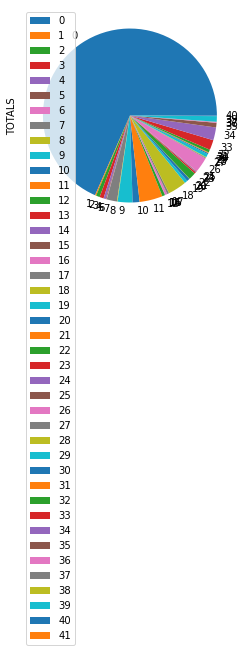

In [9]:
#Pie chart of totals
plot = cuy_data.plot.pie(y='TOTALS')

### Bar charts of Population data and Violent crime

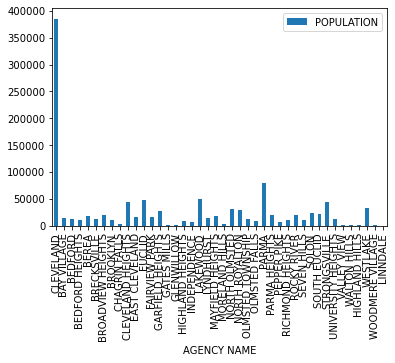

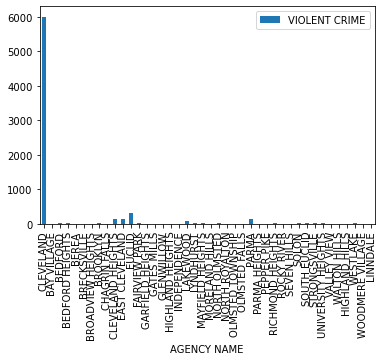

In [10]:
cuy_data.plot.bar(x="AGENCY NAME", y="POPULATION")
cuy_data.plot.bar(x="AGENCY NAME", y="VIOLENT CRIME")

### Created Lists to store Race Data for Crime in Cleveland in 2017

In [11]:
asian=[]
black=[]
amer_ind=[]
white=[]
unknown=[]

### Used FBI Crime API to obtain Race Data for all Crimes in Cle for 2017

In [12]:
#Get Violent crime data for Cle 2017
url_race=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/violent-crime/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_race).json()

In [13]:
#Get Asian count for violent crime in Cle
asian.append(response["data"][13]["value"])

In [14]:
#Get Black or African American count for violent crime in Cle
black.append(response["data"][43]["value"])

In [15]:
#Get American Indian count for violent crime in Cle
amer_ind.append(response["data"][58]["value"])

In [16]:
#Get White count for violent crime in Cle
white.append(response["data"][73]["value"])

In [17]:
#Get Unknown count for violent crime in Cle
unknown.append(response["data"][88]["value"])

In [18]:
#Get 2017 Property Crime data for Cle
url_property=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/property-crime/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_property).json()

In [19]:
#Get Asian count for property crime in Cle 
asian.append(response["data"][13]["value"])

In [20]:
#Get Black or African American count for property crime in Cle
black.append(response["data"][43]["value"])

In [21]:
#Get American Indian count for property crime in Cle
amer_ind.append(response["data"][58]["value"])

In [22]:
#Get White count for property crime in Cle
white.append(response["data"][73]["value"])

In [23]:
#Get Unknown count for property crime in Cle
unknown.append(response["data"][88]["value"])

In [24]:
#Get 2017 Homicide data for Cle
url_homicide=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/homicide/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_homicide).json()

In [25]:
#Get Asian count for homicide crime in Cle 
asian.append(response["data"][13]["value"])


In [26]:
#Get Black or African American count for homicide crime in Cle
black.append(response["data"][43]["value"])

In [27]:
#Get American Indian count for homicide crime in Cle
amer_ind.append(response["data"][58]["value"])

In [28]:
#Get White count for homicide crime in Cle
white.append(response["data"][73]["value"])

In [29]:
#Get Unknown count for homicide crime in Cle
unknown.append(response["data"][88]["value"])

In [30]:
#Get Rape data for Cle 2017
url_rape=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/rape/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_rape).json()


In [31]:
#Get Asian count for rape crime in Cle 
asian.append(response["data"][13]["value"])


In [32]:
#Get Black or African American count for rape crime in Cle
black.append(response["data"][43]["value"])

In [33]:
#Get American Indian count for rape crime in Cle
amer_ind.append(response["data"][58]["value"])


In [34]:
#Get White count for rape crime in Cle
white.append(response["data"][73]["value"])

In [35]:
#Get Unknown count for rape crime in Cle
unknown.append(response["data"][88]["value"])

In [36]:
#Get Robbery data for Cle 2017
url_robbery=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/robbery/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_robbery).json()

In [37]:
#Get Asian count for robbery crime in Cle 
asian.append(response["data"][13]["value"])


In [38]:
#Get Black or African American count for robbery crime in Cle
black.append(response["data"][43]["value"])

In [39]:
#Get American Indian count for robbery crime in Cle
amer_ind.append(response["data"][58]["value"])

In [40]:
#Get White count for robbery crime in Cle
white.append(response["data"][73]["value"])

In [41]:
#Get Unknown count for robbery crime in Cle
unknown.append(response["data"][88]["value"])

In [42]:
#Get Aggravated Assault data for Cle 2017
url_agg_assault=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/aggravated-assault/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_agg_assault).json()

In [43]:
#Get Asian count for aggravated assault crime in Cle 
asian.append(response["data"][13]["value"])


In [44]:
#Get Black or African American count for aggravated assault crime in Cle
black.append(response["data"][43]["value"])

In [45]:
#Get American Indian count for aggravated assault crime in Cle
amer_ind.append(response["data"][58]["value"])

In [46]:
#Get White count for aggravated assault crime in Cle
white.append(response["data"][73]["value"])

In [47]:
#Get Unknown count for aggravated assault crime in Cle
unknown.append(response["data"][88]["value"])

In [48]:
#Get Arson data for Cle 2017
url_arson=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/arson/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_arson).json()

In [49]:
#Get Asian count for arson crime in Cle 
asian.append(response["data"][13]["value"])


In [50]:
#Get Black or African American count for arson crime in Cle
black.append(response["data"][43]["value"])


In [51]:
#Get American Indian count for arson crime in Cle
amer_ind.append(response["data"][58]["value"])

In [52]:
#Get White count for arson crime in Cle
white.append(response["data"][73]["value"])

In [53]:
#Get Unknown count for arson crime in Cle
unknown.append(response["data"][88]["value"])

In [54]:
#Get Motor Vehicle Theft data for 2017
url_car=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/motor-vehicle-theft/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_car).json()

In [55]:
#Get Asian count for motor-vehicle-theft crime in Cle 
asian.append(response["data"][13]["value"])


In [56]:
#Get Black or African American count for motor-vehicle-theft crime in Cle
black.append(response["data"][43]["value"])

In [57]:
#Get American Indian count for motor-vehicle-theft crime in Cle
amer_ind.append(response["data"][58]["value"])


In [58]:
#Get White count for robbery motor-vehicle-theft in Cle
white.append(response["data"][73]["value"])

In [59]:
#Get Unknown count for robbery motor-vehicle-theft in Cle
unknown.append(response["data"][88]["value"])

In [60]:
#Get Burlary data for Cle 2017
url_burglary=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/burglary/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_burglary).json()

In [61]:
#Get Asian count for burglary crime in Cle 
asian.append(response["data"][13]["value"])

In [62]:
#Get Black or African American count for burglary crime in Cle
black.append(response["data"][43]["value"])

In [63]:
#Get American Indian count for burglary crime in Cle
amer_ind.append(response["data"][58]["value"])

In [64]:
#Get White count for burglary crime in Cle
white.append(response["data"][73]["value"])

In [65]:
#Get Unknown count for burglary crime in Cle
unknown.append(response["data"][88]["value"])

In [66]:
#Get Larceny data for Cle 2017
url_larceny=f"https://api.usa.gov/crime/fbi/sapi/api/nibrs/larceny/offender/agencies/OHCLP0000/race?api_key={fbi_key}"
response=requests.get(url_larceny).json()

In [67]:
#Get Asian count for larceny crime in Cle 
asian.append(response["data"][13]["value"])

In [68]:
#Get Black or African American count for larceny crime in Cle
black.append(response["data"][43]["value"])

In [69]:
#Get American Indian count for larceny crime in Cle
amer_ind.append(response["data"][58]["value"])

In [70]:
#Get White count for larceny crime in Cle
white.append(response["data"][73]["value"])

In [71]:
#Get Unknown count for larceny crime in Cle
unknown.append(response["data"][88]["value"])

In [72]:
#Make crime list for Race DataFrame
crimes=["Violent Crime", "Property Crime", "Homicide", "Rape", "Robbery", "Aggravated Assault",
       "Arson", "Motor Vehicle Theft", "Burglary", "Larceny"]

### Created Data Frame of Race Data for all Crimes categories for Cleveland in 2017

In [73]:
#Make Dataframe for Race Count
race_data= { "Crimes": crimes,
           "Asian Count": asian,
           "Black Count": black,
           "American Indian Count": amer_ind,
           "White Count": white,
           "Unknown Race": unknown}

race_data_df = pd.DataFrame(race_data)
race_data_df


,Crimes,Asian Count,Black Count,American Indian Count,White Count,Unknown Race
0,Violent Crime,16,3986,3,708,408
1,Property Crime,16,4936,5,1849,2824
2,Homicide,0,46,0,2,10
3,Rape,2,342,0,120,31
4,Robbery,6,2088,0,252,190
5,Aggravated Assault,8,1510,3,334,177
6,Arson,0,42,0,26,12
7,Motor Vehicle Theft,1,617,1,164,133
8,Burglary,5,1356,0,463,1015
9,Larceny,10,2921,4,1196,1664


In [74]:
#Crimes by age pulling from api
url_agevc =f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/violent-crime/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agevc).json()
print(json.dumps(response, indent=4, sort_keys=True))

     "month_num": 0,
            "value": 1492
        },
        {
            "data_year": 2007,
            "key": "10-19",
            "month_num": 0,
            "value": 1281
        },
        {
            "data_year": 2008,
            "key": "10-19",
            "month_num": 0,
            "value": 1382
        },
        {
            "data_year": 2009,
            "key": "10-19",
            "month_num": 0,
            "value": 1176
        },
        {
            "data_year": 2010,
            "key": "10-19",
            "month_num": 0,
            "value": 1182
        },
        {
            "data_year": 2011,
            "key": "10-19",
            "month_num": 0,
            "value": 1028
        },
        {
            "data_year": 2012,
            "key": "10-19",
            "month_num": 0,
            "value": 1011
        },
        {
            "data_year": 2013,
            "key": "10-19",
            "month_num": 0,
            "value": 1033
        },
    

In [75]:
#2017 violent crimes by age
vc_age0_9 = response["data"][13]["value"]
vc_age10_19 = response["data"][28]["value"]
vc_age20_29 = response["data"][43]["value"]
vc_age30_39 = response["data"][58]["value"]
vc_age40_49 = response["data"][73]["value"]
vc_age50_59 = response["data"][88]["value"]
vc_age60_69 = response["data"][103]["value"]
vc_age70_79 = response["data"][118]["value"]
vc_age80_89 = response["data"][133]["value"]
vc_age90_Older = response["data"][148]["value"]

vc_list = [vc_age0_9, vc_age10_19, vc_age20_29, vc_age30_39, vc_age40_49, vc_age50_59, vc_age60_69, vc_age70_79, vc_age80_89, vc_age90_Older]

In [76]:
#2017 property crimes by age
url_agepc =f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/property-crime/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agepc).json()

pc_age0_9 = response["data"][13]["value"]
pc_age10_19 = response["data"][28]["value"]
pc_age20_29 = response["data"][43]["value"]
pc_age30_39 = response["data"][58]["value"]
pc_age40_49 = response["data"][73]["value"]
pc_age50_59 = response["data"][88]["value"]
pc_age60_69 = response["data"][103]["value"]
pc_age70_79 = response["data"][118]["value"]
pc_age80_89 = response["data"][133]["value"]
pc_age90_Older = response["data"][148]["value"]
pc_list = [pc_age0_9, pc_age10_19, pc_age20_29, pc_age30_39, pc_age40_49, pc_age50_59, pc_age60_69, pc_age70_79, pc_age80_89, pc_age90_Older]

In [77]:
#2017 aggravated assault by age
url_ageaa = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/aggravated-assault/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_ageaa).json()

aa_age0_9 = response["data"][13]["value"]
aa_age10_19 = response["data"][28]["value"]
aa_age20_29 = response["data"][43]["value"]
aa_age30_39 = response["data"][58]["value"]
aa_age40_49 = response["data"][73]["value"]
aa_age50_59 = response["data"][88]["value"]
aa_age60_69 = response["data"][103]["value"]
aa_age70_79 = response["data"][118]["value"]
aa_age80_89 = response["data"][133]["value"]
aa_age90_Older = response["data"][148]["value"]
aa_list = [aa_age0_9, aa_age10_19, aa_age20_29, aa_age30_39, aa_age40_49, aa_age50_59, aa_age60_69, aa_age70_79, aa_age80_89, aa_age90_Older]

In [78]:
#2017 burglary by age
url_ageburglary = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/burglary/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_ageburglary).json()
burglary_age0_9 = response["data"][13]["value"]
burglary_age10_19 = response["data"][28]["value"]
burglary_age20_29 = response["data"][43]["value"]
burglary_age30_39 = response["data"][58]["value"]
burglary_age40_49 = response["data"][73]["value"]
burglary_age50_59 = response["data"][88]["value"]
burglary_age60_69 = response["data"][103]["value"]
burglary_age70_79 = response["data"][118]["value"]
burglary_age80_89 = response["data"][133]["value"]
burglary_age90_Older = response["data"][148]["value"]
burglary_list = [burglary_age0_9, burglary_age10_19, burglary_age20_29, burglary_age30_39, burglary_age40_49, burglary_age50_59, burglary_age60_69, burglary_age70_79, burglary_age80_89, burglary_age90_Older]


In [79]:
#2017 larceny by age
url_agelarceny = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/larceny/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agelarceny).json()
larceny_age0_9 = response["data"][13]["value"]
larceny_age10_19 = response["data"][28]["value"]
larceny_age20_29 = response["data"][43]["value"]
larceny_age30_39 = response["data"][58]["value"]
larceny_age40_49 = response["data"][73]["value"]
larceny_age50_59 = response["data"][88]["value"]
larceny_age60_69 = response["data"][103]["value"]
larceny_age70_79 = response["data"][118]["value"]
larceny_age80_89 = response["data"][133]["value"]
larceny_age90_Older = response["data"][148]["value"]
larceny_list = [larceny_age0_9, larceny_age10_19, larceny_age20_29, larceny_age30_39, larceny_age40_49, larceny_age50_59, larceny_age60_69, larceny_age70_79, larceny_age80_89, larceny_age90_Older]


In [80]:
#2017 mvt by age
url_agemvt = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/motor-vehicle-theft/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agemvt).json()
mvt_age0_9 = response["data"][13]["value"]
mvt_age10_19 = response["data"][28]["value"]
mvt_age20_29 = response["data"][43]["value"]
mvt_age30_39 = response["data"][58]["value"]
mvt_age40_49 = response["data"][73]["value"]
mvt_age50_59 = response["data"][88]["value"]
mvt_age60_69 = response["data"][103]["value"]
mvt_age70_79 = response["data"][118]["value"]
mvt_age80_89 = response["data"][133]["value"]
mvt_age90_Older = response["data"][148]["value"]
mvt_list = [mvt_age0_9, mvt_age10_19, mvt_age20_29, mvt_age30_39, mvt_age40_49, mvt_age50_59, mvt_age60_69, mvt_age70_79, mvt_age80_89, mvt_age90_Older]

In [81]:
#2017 homicide by age
url_agehomicide = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/homicide/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agehomicide).json()
homicide_age0_9 = response["data"][13]["value"]
homicide_age10_19 = response["data"][28]["value"]
homicide_age20_29 = response["data"][43]["value"]
homicide_age30_39 = response["data"][58]["value"]
homicide_age40_49 = response["data"][73]["value"]
homicide_age50_59 = response["data"][88]["value"]
homicide_age60_69 = response["data"][103]["value"]
homicide_age70_79 = response["data"][118]["value"]
homicide_age80_89 = response["data"][133]["value"]
homicide_age90_Older = response["data"][148]["value"]
homicide_list = [homicide_age0_9, homicide_age10_19, homicide_age20_29, homicide_age30_39, homicide_age40_49, homicide_age50_59, homicide_age60_69, homicide_age70_79, homicide_age80_89, homicide_age90_Older]

In [82]:
#2017 rape by age
url_agerape = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/rape/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agerape).json()
rape_age0_9 = response["data"][13]["value"]
rape_age10_19 = response["data"][28]["value"]
rape_age20_29 = response["data"][43]["value"]
rape_age30_39 = response["data"][58]["value"]
rape_age40_49 = response["data"][73]["value"]
rape_age50_59 = response["data"][88]["value"]
rape_age60_69 = response["data"][103]["value"]
rape_age70_79 = response["data"][118]["value"]
rape_age80_89 = response["data"][133]["value"]
rape_age90_Older = response["data"][148]["value"]

rape_list = [rape_age0_9, rape_age10_19, rape_age20_29, rape_age30_39, rape_age40_49, rape_age50_59, rape_age60_69, rape_age70_79, rape_age80_89, rape_age90_Older]

In [83]:
#2017 robbery by age
url_agerobbery = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/robbery/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agerobbery).json()
robbery_age0_9 = response["data"][13]["value"]
robbery_age10_19 = response["data"][28]["value"]
robbery_age20_29 = response["data"][43]["value"]
robbery_age30_39 = response["data"][58]["value"]
robbery_age40_49 = response["data"][73]["value"]
robbery_age50_59 = response["data"][88]["value"]
robbery_age60_69 = response["data"][103]["value"]
robbery_age70_79 = response["data"][118]["value"]
robbery_age80_89 = response["data"][133]["value"]
robbery_age90_Older = response["data"][148]["value"]
robbery_list = [robbery_age0_9, robbery_age10_19, robbery_age20_29, robbery_age30_39, robbery_age40_49, robbery_age50_59, robbery_age60_69, robbery_age70_79, robbery_age80_89, robbery_age90_Older]


In [84]:
#2017 arson by age
url_agearson = f"https://api.usa.gov/crime/fbi/sapi//api/nibrs/arson/offender/agencies/OHCLP0000/age?api_key={fbi_key}"
response=requests.get(url_agearson).json()
arson_age50_59 = response["data"][88]["value"]
arson_age60_69 = response["data"][103]["value"]
arson_age70_79 = response["data"][118]["value"]
arson_age0_9 = response["data"][13]["value"]
arson_age10_19 = response["data"][28]["value"]
arson_age20_29 = response["data"][43]["value"]
arson_age30_39 = response["data"][58]["value"]
arson_age40_49 = response["data"][73]["value"]
arson_age80_89 = response["data"][133]["value"]
arson_age90_Older = response["data"][148]["value"]
arson_list = [arson_age0_9, arson_age10_19, arson_age20_29, arson_age30_39, arson_age40_49, arson_age50_59, arson_age60_69, arson_age70_79, arson_age80_89, arson_age90_Older]


In [85]:
#create dataframe for age data
age_list= ['0-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-Older', 'unknown']
cle2017_crime_age_df = pd.DataFrame(list(zip(age_list, vc_list, pc_list, aa_list, burglary_list, larceny_list, mvt_list, homicide_list ,rape_list, robbery_list, arson_list)),columns=["Age Groups", "Violent-Crime", "Property-Crime", "Aggravated-Assault", "Burglary", "Larceny", "Motor-Vehicle-Theft", "Homicide", "Rape", "Robbery", "Arson"])
cle2017_crime_age_df


,Age Groups,Violent-Crime,Property-Crime,Aggravated-Assault,Burglary,Larceny,Motor-Vehicle-Theft,Homicide,Rape,Robbery,Arson
0,0-9,23,58,5,14,39,1,0,14,4,4
1,10-19,776,1025,189,263,547,194,7,80,500,21
2,20-29,1357,1823,588,529,1057,220,21,118,630,17
3,30-39,680,1315,358,348,797,159,10,81,231,11
4,40-49,375,753,211,171,526,49,7,53,104,7
5,50-59,278,553,154,125,381,38,1,44,79,9
6,60-69,63,121,43,23,92,3,2,13,5,3
7,70-79,13,13,9,3,8,1,0,1,3,1
8,80-89,2,3,1,0,2,1,0,1,0,0
9,90-Older,2,3,0,0,3,0,0,0,2,0
